# Fase 3 - Proyecto Machine Learning

In [35]:
#Funciones y librerias
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from scipy.stats import mode

def pca_explain(X_scaled):
    pca_2 = PCA(n_components = 2)
    pca_result = pca_2.fit_transform(X_scaled)
    print('Variación explicada por PCA: {}'.format(pca_2.explained_variance_ratio_))
    print('Varianza acumulada por 2 componentes principales: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))
    dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=X.columns, index=['PC_1', 'PC_2'])
    print('\n\n', dataset_pca)
    return(pca_2, pca_result)

def elbow_method(X_scaled):
    wcc_list = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters = i, random_state = 42)
        kmeans.fit(X_scaled)
        wcc_list.append(kmeans.inertia_)
    plt.plot(range(1,11), wcc_list)
    plt.title('Método Elbow')
    plt.xlabel('No. Clusters')
    plt.ylabel('wcc_list')
    plt.show()

def kmeans_algorithm(X_scaled, pca_2, pca_result, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X_scaled)
    centroids = kmeans.cluster_centers_
    centroids_pca = pca_2.transform(centroids)
    x = pca_result[:,0]
    y = pca_result[:,1]
    plt.scatter(x,y, c=kmeans.labels_, alpha=.5, s = 200)
    plt.title('Clusters')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=100, linewidths=1.5,
            color='red', edgecolors="black")
    plt.show()
    return (kmeans.labels_)

def cm_plot(true_label, pred_cluster):
    cm = confusion_matrix(true_label, pred_cluster)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_label), yticklabels=np.unique(true_label))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Ejercicio 1

Utilizando la situación modelada en las fases anteriores, ¿Cuáles serían los algoritmos de aprendizaje automático no supervisado que consideras que deberían estar involucrados de alguna forma en tu propuesta anterior?

Recapitulando un poco sobre la situación, se presenta el siguiente problema:

La *Fase 1* del proyecto consistía en:

En una planta industrial se está considerando la introducción de un vehículo inteligente que sea capaz de trasladarse de forma autónoma a través de las instalaciones y de transportar los productos desde el área de almacenamiento central hasta las diferentes zonas de manufactura. La empresa tiene tres áreas de manufactura y cada producto se encuentra empacado en un contenedor específico que identifica el área a la que pertenece.

Durante la *Fase 2*, se realizó un modelo utilizando un algoritmo de aprendizaje supervisado que fuera capaz de determinar el tipo de protocolo que debía seguir el vehículo al manipular un producto cualquiera en el proyecto de almacen a la zona de manufactura.

El modelo utilizado fue un árbol de decisión XGBoost. Dicho desarrollo se encuentra en la ubicación de *'../Fase1/Fase 2 - ML.ipynb'*. El modelo retornó las siguientes métricas:

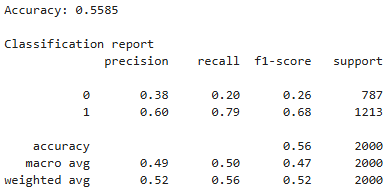

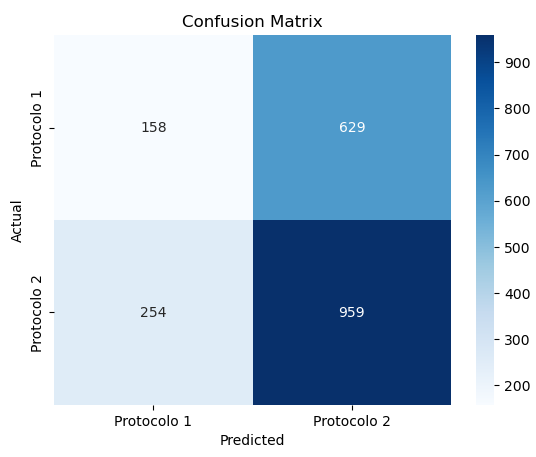


Hay múltiples modelos que se pueden proponer para clasificar a los productos entre los distintos depositos, sin embargo, una opción que nos puede servir para este modelo, es el algoritmo de **K-Means**. Dicho algoritmo es una técnica de clasificación no supervisada que agrupa los objetos en k grupos, basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o clúster.

## Ejercicio 2

Considera que el vehículo autónomo debe incorporar la función de organizar, de manera automática, los productos que transporta al momento de llegar a cada una de las áreas de manufactura. 

Construye un modelo de aprendizaje automático no supervisado, que, a partir del conjunto de datos utilizado en la fase anterior, ubique cada producto en uno de los cuatro depósitos disponibles que se encuentran en cada área.

Utilizaré el mismo dataset que se generó en la Fase 2 del proyecto.

In [3]:
df = pd.read_csv(r'data/Fase2_ML - Datos.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.head(5)

,ID_PAQUETE,CATEGORIA_ASIGNADA,ALTO,ANCHO,LARGO,PESO_ASIGNADO,TIPO_MANIPULACION,LUGAR_PROCEDENCIA,TEMPERATURA_ALMACENAMIENTO,PROTOCOLO,LUGAR_PROCEDENCIA_WOE,TIPO_MANIPULACION_NUM,TEMPERATURA_ALMACENAMIENTO_NUM,PROTOCOLO_TARGET
0,1,pequeño,11.25,16.58,17.13,8.096204,normal,B,ambiente,Protocolo_2,0.049232,1,1,0
1,2,mediano,36.87,33.50,41.15,24.975459,fragil,D,ambiente,Protocolo_2,-0.009582,0,1,0
2,3,pequeño,11.99,14.11,15.45,4.946614,normal,A,refrigerado,Protocolo_1,-0.075119,1,0,1
3,4,pequeño,11.79,16.20,18.42,9.365610,normal,C,ambiente,Protocolo_2,0.040459,1,1,0
4,5,pequeño,12.47,13.49,17.03,7.179166,normal,B,refrigerado,Protocolo_1,0.049232,1,0,1


In [11]:
#Convertir A,B,C,D a 0,1,2,3
df['True_label'] = df['LUGAR_PROCEDENCIA'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3})

C:\Users\Usuario\AppData\Local\Temp\ipykernel_60540\3277719368.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['True_label'] = df['LUGAR_PROCEDENCIA'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3})


Varias columnas fueron modificadas con el fin de obtener mayor valores para la predicción de protocolo. Dado que ahora estamos prediciendo el lugar de procedencia. Solo consideraremos las siguientes variables:

-  Alto
-  Ancho
-  Largo
-  Peso Asinado
-  Temperatura almacenamiento
-  Tipo de manipulación

**Utilizando K-Means**

Si se utiliza KMeans suele ser más util usando pocas variables, como este no es el caso. Reduciremos la dimensionalidad utilizando PCA.

In [15]:
X = df[['ALTO', 'ANCHO', 'LARGO', 'PESO_ASIGNADO','TEMPERATURA_ALMACENAMIENTO_NUM', 'TIPO_MANIPULACION_NUM']]

In [17]:
#Estandarizamos la informacion para un mejor desempeño
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
pca, pca_result = pca_explain(X_scaled)

Variación explicada por PCA: [0.62364565 0.16718747]
Varianza acumulada por 2 componentes principales: 79.08%


           ALTO     ANCHO     LARGO  PESO_ASIGNADO  \
PC_1  0.505054  0.504144  0.505200       0.485313   
PC_2  0.002178  0.000992  0.002232       0.002316   

      TEMPERATURA_ALMACENAMIENTO_NUM  TIPO_MANIPULACION_NUM  
PC_1                        0.000471               0.001785  
PC_2                        0.705889               0.708311  


Realizando la reduccion de dimensionalidad, obtenemos el resultado que aún conservamos el 79% de información de nuestro set original. Siendo un porcentaje bastante alto.

Además, cada componente creado en PCA, conserva bastante originalidad en los datos, a lo mucho en la variable de *TIPO_MANIPULACION_NUM* se conserva un número bajo de información, al igual que en la variable de *PESO_ASIGNADO*.

Esto demuestra que la reducción de dimensionalidad es bastante útil para este modelo.

¿Qué numero de clusters es el mejor?

A priori, utilizar un modelo no supervisado para un set de datos con pocas variables y que en teoría no es un set de datos no supervisado, no es la mejor idea. Sin embargo, suponiendo que NO existieran los lugares de procedencia, elegir el número de clusters en este algoritmo es una tarea importante. Inicialmente se sabe que se cuentan con 4 clusters (lugares de procedencia). Sin embargo, proponer un número alto o bajo de clusters suele resultar en una erronea clasificación. 

De igual manera, se muestra una opción para mostrar el número óptimo de clústers que se suele utilizar en *KMeans*, esta técnica es el **método Elbow**. 

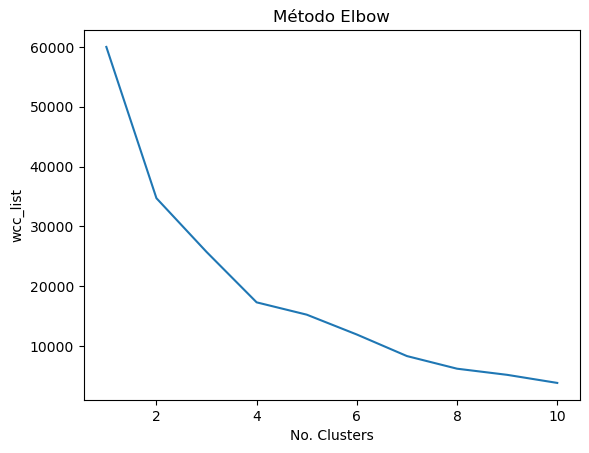

In [21]:
elbow_method(X_scaled)

La gráfica muestra que el mejor número de clusters podría estar entre **n=[3,4]**. Esto se puede deber a distintas razones, considerando la información tomada, se puede deber a lo siguiente:

- Se cuentan con 3 distintos tamaños (pequeño, mediano y grande) y está directamente relacionado con el peso y las medidas (alto, ancho y largo), el algoritmo relaciona estas variables y por ende, propone 3 clústeres.

Ahora, se encuentra la duda de ¿Qué pasaría si se intentan con 4 clústeres?

### Utilizando 4 clústeres

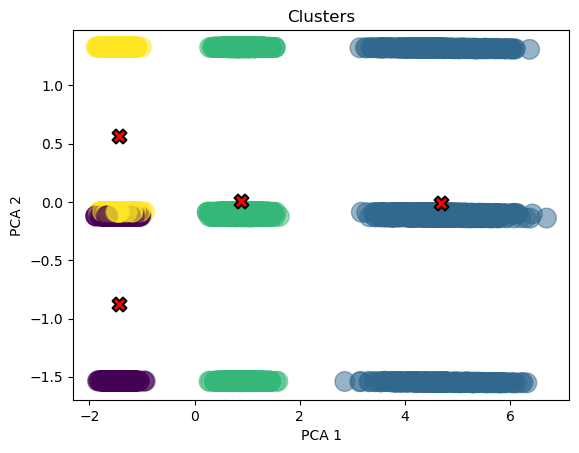

In [51]:
pred_n4 = kmeans_algorithm(X_scaled, pca, pca_result, 4)

### Utilizando 3 clústers

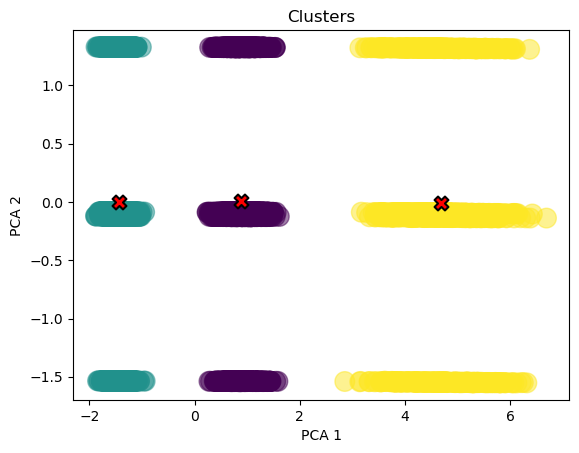

In [57]:
pred_n3 = kmeans_algorithm(X_scaled, pca, pca_result, 3)

### ¿Qué tan bueno es el algoritmo?

A pesar que es un modelo no supervisado, se tiene claridad en los lugares de procedencia, por ende, se puede realizar una comparación entre los clusters predichos para cada observacion y los reales. 

#### Para clusters n = 4

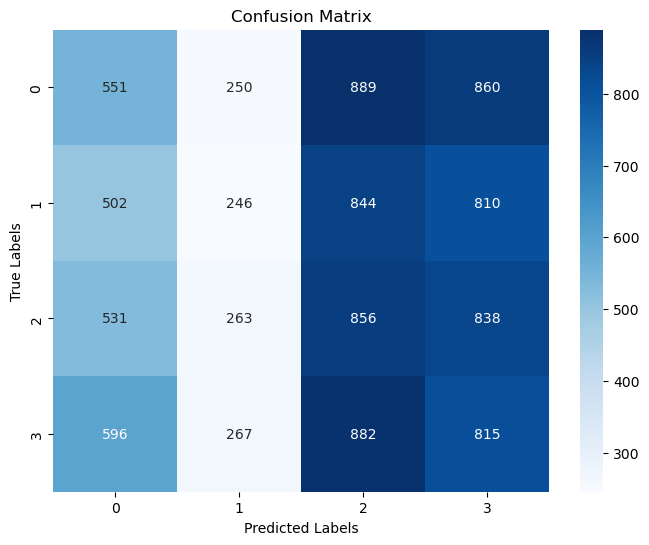

In [59]:
cm_plot(df['True_label'], pred_n4)

In [61]:
cluster_to_class = {}
for cluster in np.unique(pred_n4):
    mask = (pred_n4 == cluster)
    cluster_to_class[cluster] = mode(df['True_label'][mask])[0]

# Map the predicted clusters to the true labels
predicted_labels = np.array([cluster_to_class[cluster] for cluster in pred_n4])

# Calculate accuracy
accuracy = accuracy_score(df['True_label'], predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.2612


#### Para clusters n = 3

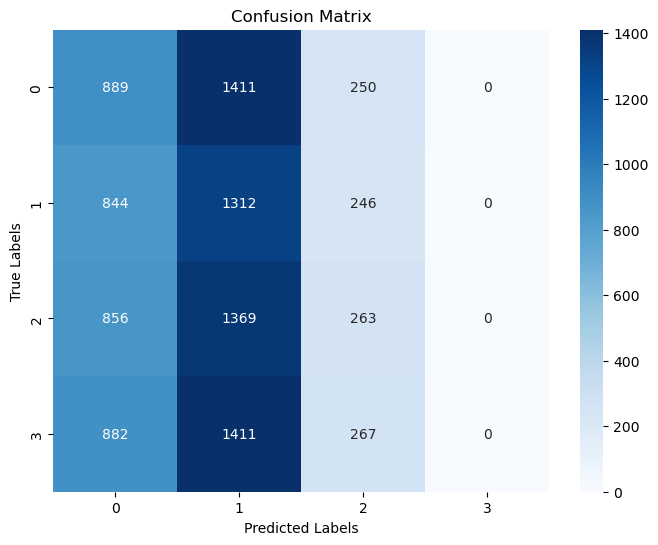

In [63]:
cm_plot(df['True_label'], pred_n3)

In [65]:
cluster_to_class = {}
for cluster in np.unique(pred_n3):
    mask = (pred_n3 == cluster)
    cluster_to_class[cluster] = mode(df['True_label'][mask])[0]

# Map the predicted clusters to the true labels
predicted_labels = np.array([cluster_to_class[cluster] for cluster in pred_n3])

# Calculate accuracy
accuracy = accuracy_score(df['True_label'], predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.2567
